* pip install -U scikit-allel
* pip install vcfnp
* pip install petl
* pip install seaborn

Heavily munged from [The Scikit Allel walkthrough](http://alimanfoo.github.io/2015/09/28/fast-pca.html), and the [vcfnp notebook](http://nbviewer.ipython.org/github/alimanfoo/vcfnp/blob/master/example.ipynb)

In [1]:
%matplotlib inline

import matplotlib
#matplotlib.use('SVG')

from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas
import vcfnp
import allel
from allel.util import *
import os
vcfnp.__version__

'2.3.0'

### Set up data dirs to pull from

In [2]:
DATA_DIR="/Users/iovercast/Dropbox/Tumbes-Maranon-Project/Pyrad-output/Step6/"
POPS_FILES_DIR="/Users/iovercast/Dropbox/Tumbes-Maranon-Project/Fastsimcoal2/PopsFiles/"

In [3]:
specieslist = os.listdir(DATA_DIR)
print(specieslist)
scientific_names = {"Arremon":"A. abeillei",\
                    "Campylorhynchus":"C. fasciatus",\
                    "Melanopareia":"M. maranonica/M. elegans",\
                    "Mimus":"M. longicaudatus",\
                    "Saltator":"S. striatipectus",\
                    "Thamnophilus":"T. bernardi"}

['Arremon', 'Campylorhynchus', 'Melanopareia', 'Mimus', 'Saltator', 'Thamnophilus']


### Helper functions for plotting

In [4]:
pop_colours = {
    'Mar': '#FF0000',
    'Tum': '#0000FF'
}

# This isn't used right now.
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.stats.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)
    
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

df_samples = []
populations = []

## Only plot the first 2 pcs
def fig_pca12(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = df_samples[1].values
    # plot coords for PCs 1 vs 2
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()

## Plot PCs 1-4
def fig_pca14(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = df_samples[1].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    
def get_pops( species ):
    # load the populations files
    df_samples = pandas.read_csv(POPS_FILES_DIR+species+"_pops.txt", delimiter=" ", header=None)

    df_samples.head()
    populations = df_samples[1].unique()
    return( df_samples, populations )

# Drop the bad individual from Mimus

In [5]:
df_samples, populations = get_pops("Mimus")
print(df_samples)
#print(type(df_samples))
df_samples = df_samples.drop(6)
#df_samples = np.delete(df_samples,(6), axis=0)
print(df_samples)


                   0    1
0   MarMimLonAWK3714  Mar
1   MarMimLonAWK3911  Mar
2    MarMimLonCSF324  Mar
3    MarMimLonCSF354  Mar
4    MarMimLonCSF360  Mar
5    MarMimLonCSF364  Mar
6    MarMimLonEHY062  Mar
7    MarMimLonEHY092  Mar
8    MarMimLonJAO075  Mar
9    MarMimLonJAO078  Mar
10   MarMimLonJAO102  Mar
11   MarMimLonJAO194  Mar
12   MarMimLonOMT105  Mar
13  TumMimLonAWK3964  Tum
14    TumMimLonB5229  Tum
15   TumMimLonCSF472  Tum
16   TumMimLonCSF551  Tum
17   TumMimLonCSF554  Tum
18   TumMimLonCSF556  Tum
19   TumMimLonEHY397  Tum
20   TumMimLonEHY417  Tum
21   TumMimLonJAO289  Tum
                   0    1
0   MarMimLonAWK3714  Mar
1   MarMimLonAWK3911  Mar
2    MarMimLonCSF324  Mar
3    MarMimLonCSF354  Mar
4    MarMimLonCSF360  Mar
5    MarMimLonCSF364  Mar
7    MarMimLonEHY092  Mar
8    MarMimLonJAO075  Mar
9    MarMimLonJAO078  Mar
10   MarMimLonJAO102  Mar
11   MarMimLonJAO194  Mar
12   MarMimLonOMT105  Mar
13  TumMimLonAWK3964  Tum
14    TumMimLonB5229  Tum
15   TumMimL

## For each species go through and read the genotype data in to the distances dict. It also does some plots, but i don't feel like turning them off.

Doing - Arremon


[vcfnp] 2016-11-22 18:51:06.121941 :: caching is disabled
[vcfnp] 2016-11-22 18:51:06.124020 :: building array
[vcfnp] 2016-11-22 18:51:17.569043 :: caching is disabled
[vcfnp] 2016-11-22 18:51:17.571403 :: building array


Doing - Campylorhynchus


[vcfnp] 2016-11-22 18:51:23.427628 :: caching is disabled
[vcfnp] 2016-11-22 18:51:23.431053 :: building array


Doing - Melanopareia


[vcfnp] 2016-11-22 18:51:34.105970 :: caching is disabled
[vcfnp] 2016-11-22 18:51:34.108077 :: building array


Doing - Mimus


[vcfnp] 2016-11-22 18:51:41.461935 :: caching is disabled
[vcfnp] 2016-11-22 18:51:41.463970 :: building array


Doing - Saltator


[vcfnp] 2016-11-22 18:51:58.541691 :: caching is disabled
[vcfnp] 2016-11-22 18:51:58.543445 :: building array


Doing - Thamnophilus


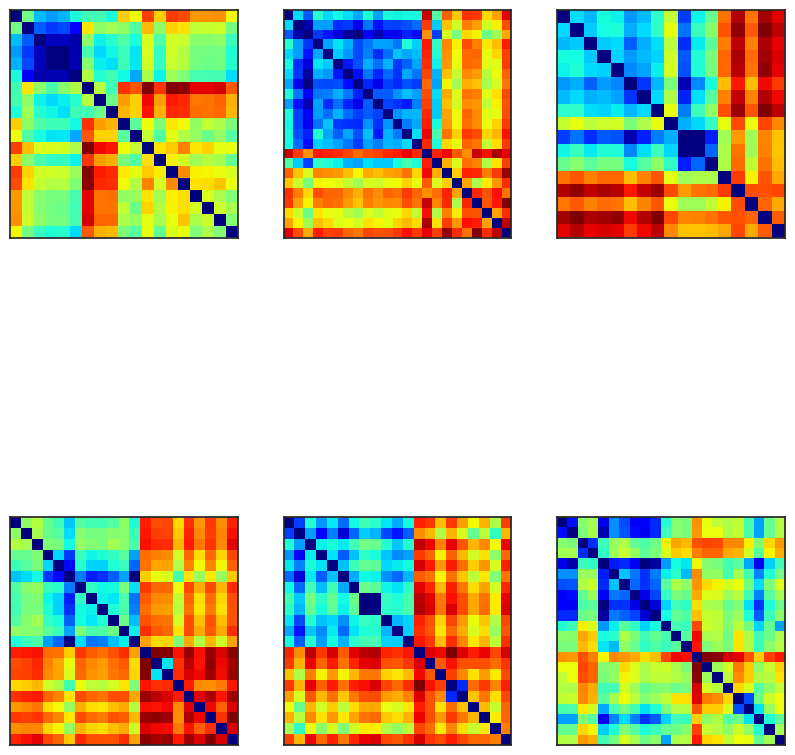

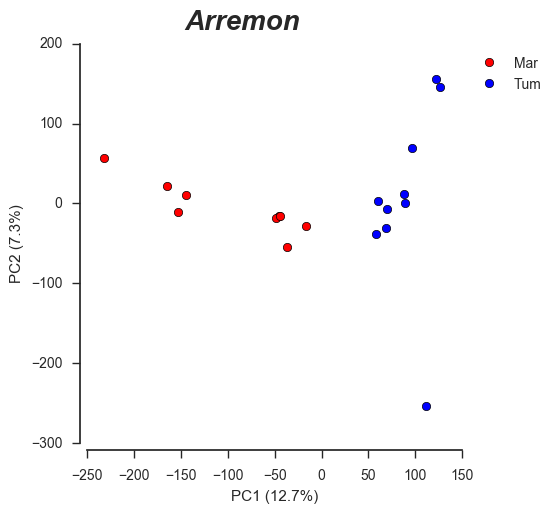

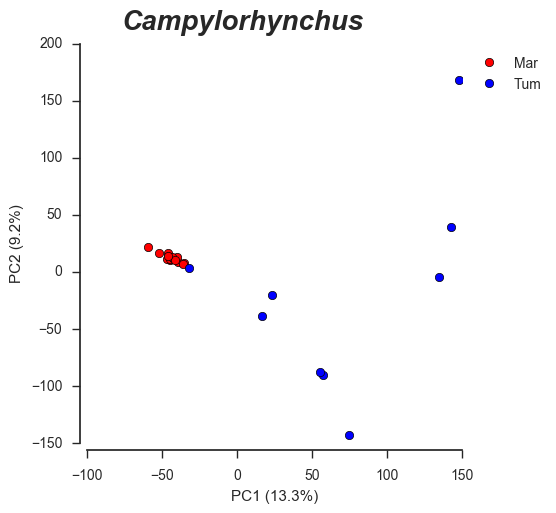

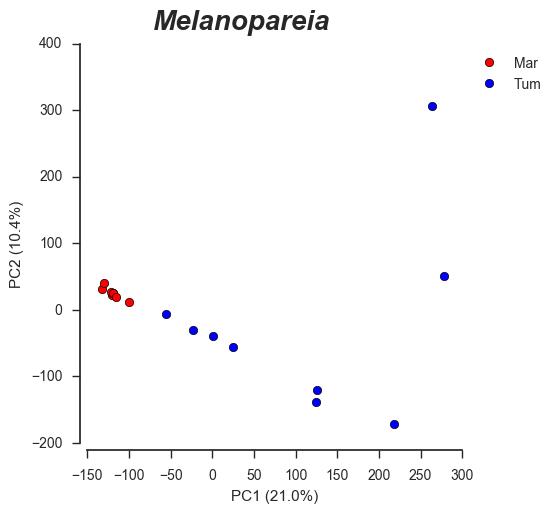

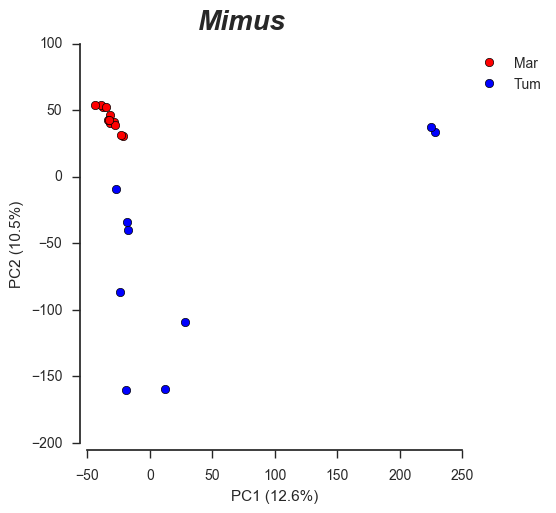

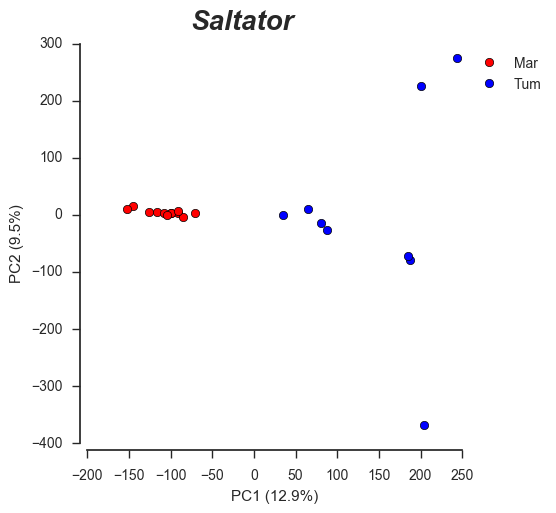

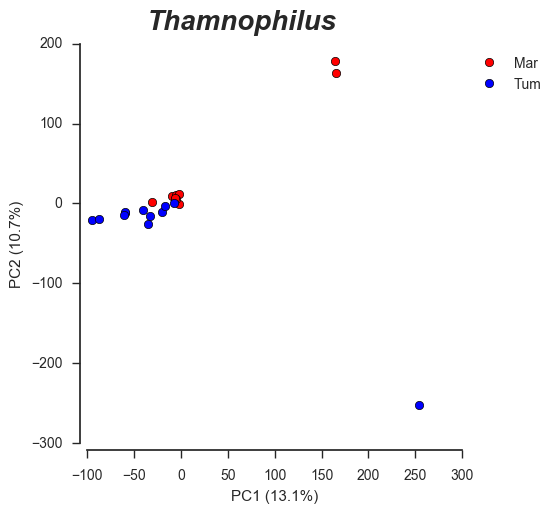

In [6]:
## Dict for storing distances so we can play with manipulating the figure w/o
## having to reimport vcf every time
distances = {}
gn_per_sp = {}

## Make the figure
#plt.figure(figsize=(20,10),dpi=1000)
f, axarr = plt.subplots(2, 3, figsize=(10,12))
axarr = [a for b in axarr for a in b]

#for species in ["Mimus"]:
for species, ax in zip(specieslist, axarr):
    print("Doing - "+species)
    # Load the vcf files
    # This is another way to load the vcf, but we don't use it.
    #v = vcfnp.variants(DATA_DIR+"Arremon/outfiles/c85d6m4p3.vcf").view(np.recarray)
    c = vcfnp.calldata_2d(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf").view(np.recarray)
    
    ## If doing mimus then delete the bad individual EHY065
    if species == "Mimus":
        c = np.delete(c,(6), axis=1)
    
    # This is technically not that interesting or useful so get rid of it if its annoying
    # print some simple genotype metrics
    count_phased = np.count_nonzero(c.is_phased)
    count_variant = np.count_nonzero(np.any(c.genotype > 0, axis=2))
    count_missing = np.count_nonzero(~c.is_called)
    #print('calls (phased, variant, missing): %s (%s, %s, %s)'
    #    % (c.flatten().size, count_phased, count_variant, count_missing))

    # Make the genotype array and count # of alleles at each position
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()

    # Munging and transforming the data into a format pca will like
    np.count_nonzero(ac.max_allele() > 1)
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()

    # Must reinitialize the df_samples np array
    df_samples = np.empty( len(ac) )
    df_samples, populations = get_pops( species )
    
    ## If doing mimus then delete the bad individual EHY065
    if species == "Mimus":
        df_samples = df_samples.drop(6)

    # Do the pca and then plot it
    gn_per_sp[species] = gn
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig_pca12(coords1, model1, species)

    # Do the pairwise distances
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    distances[species] = dist
#    allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist())
    allel.plot.pairwise_distance(dist, labels=None, ax=ax, colorbar=False)

## Do the combined plot for all species

__This is the final plot for Figure 3 for the manuscript.__

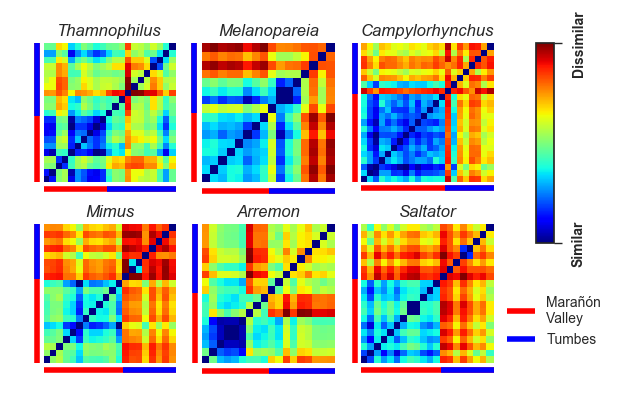

In [8]:
sp_in_order = ['Thamnophilus', 'Melanopareia', 'Campylorhynchus', 'Mimus', 'Arremon', 'Saltator']

sp_hlines = {"Thamnophilus":[10,21], 'Melanopareia':[8,16], 'Campylorhynchus':[14,22],\
             'Mimus':[12,20], 'Arremon':[9,18], 'Saltator':[12,20]}
## This is the way to do it simply w/o having the separate axis for the colorbar
f, axarr = plt.subplots(2, 3, figsize=(6,4), dpi=1000)
axarr = [a for b in axarr for a in b]

linewidth = 4
mar_col = "r"
tum_col = "b"

for species, ax in zip(sp_in_order, axarr):
    dist = distances[species]

    ## Doing it this way works, but allel uses imshow internally which rasterizes the image
    #allel.plot.pairwise_distance(dist, labels=None, ax=ax, colorbar=False)

    ## Create the pcolormesh by hand
    dat = ensure_square(dist)
    
    ## for some reason np.flipud(dat) is chopping off one row of data
    p = ax.pcolormesh(np.arange(0,len(dat[0])), np.arange(0,len(dat[0])), dat,\
        cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
    ## Clip all heatmaps to actual sample size
    p.axes.axis("tight")
    
    ax.set_title(species, style="italic")
    ax.axison = False

    ## Draw horizontal lines to indicate subpopulations
    mar_hline = ax.axhline(-1, zorder=20, linewidth=linewidth, color=mar_col, solid_capstyle="butt")
    mar_hline.set_clip_on(False)
    ## Fake line, doesn't draw but we need it for the legend.
    tum_line = ax.axhline(-2, zorder=0, linewidth=linewidth, color=tum_col, solid_capstyle="butt")
    tum_hline = ax.plot(sp_hlines[species], [-1, -1], linewidth=linewidth, color=tum_col, linestyle="-", \
                       zorder=21, solid_capstyle="butt")
    tum_hline[0].set_clip_on(False)

    ## Draw vertical lines
    mar_vline = ax.axvline(-1, zorder=20, linewidth=linewidth, color=mar_col, solid_capstyle="butt")
    mar_vline.set_clip_on(False)
    tum_vline = ax.plot([-1, -1], sp_hlines[species], linewidth=linewidth, color=tum_col, linestyle="-", zorder=21, solid_capstyle="butt")
    tum_vline[0].set_clip_on(False)
    
    ## Clean up the 0,0 box
    ax.plot([-2, -2], [-0.8, -2.1], color="w", zorder=22, linewidth=linewidth, solid_capstyle="butt")
    ax.plot([-0.75, -2.2], [-2, -2], color="w", zorder=22, linewidth=linewidth, solid_capstyle="butt")

## Add the colorbar
cax = f.add_axes([0.87, 0.4, 0.03, 0.5])
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap="jet", orientation="vertical", ticks=([0,1]))
cb1.ax.set_yticklabels(['Similar', "Dissimilar"], weight="bold", rotation="vertical")

## Add the legend
lax = f.add_axes([0.8, 0.1, 0.2, 0.2])
leg = lax.legend([mar_hline, tum_line], [u'Marañón\nValley', 'Tumbes'])
lax.axis("off")

## This doesn't do what i want it to do
#plt.subplots_adjust(right=0.05)
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.8, top=0.9, wspace=0.2, hspace=0.3)
plt.savefig("/Users/iovercast/Desktop/wat.eps", format="eps", dpi=1000)


## Calculate some population genetic summary stats for each species pair

In [9]:
#for species in ["Mimus"]:
for species in specieslist:
    print("Doing - "+species)
    # Load the vcf files
    # This is another way to load the vcf, but we don't use it.
    #v = vcfnp.variants(DATA_DIR+"Arremon/outfiles/c85d6m4p3.vcf").view(np.recarray)
    c = vcfnp.calldata_2d(DATA_DIR+species+"/outfiles/c85d6m4p3.vcf", verbose=False).view(np.recarray)

    # Make the genotype array and count # of alleles at each position
    g = allel.GenotypeArray(c.genotype)
    
    # Get the population assignments
    # Must reinitialize the df_samples np array
    #df_samples = np.empty( len(ac) )
    df_samples, populations = get_pops( species )

    pop1 = "Mar"
    pop2 = "Tum"
    pos_all = allel.SortedIndex(range(0, len(g)))
    subpops = {
        pop1: df_samples[df_samples[1] == pop1].index,
        pop2: df_samples[df_samples[1] == pop2].index,
    }

    # Filter out multi-allelic and sites that don't segragate
    # in the populations
    acs = g.count_alleles_subpops(subpops)
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
    flt = acu.is_segregating() & (acu.max_allele() == 1)
    print('retaining', np.count_nonzero(flt), 'biallelic SNPs')
    pos = pos_all.compress(flt)
    genotype = g.compress(flt, axis=0)
    biallelic_mar = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
    biallelic_tum = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
    
    # subset genotype array per population
    g_mar = g.subset(range(0, len(g)), np.where( df_samples[1] == pop1 )[0])
    g_tum = g.subset(range(0, len(g)), np.where( df_samples[1] == pop2 )[0])
    
    # Get per population allele counts
    ac_mar = g.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
    ac_tum = g.count_alleles(subpop = np.where( df_samples[1] == pop2 )[0])

    # Get pi per population
    pi_mar = allel.stats.sequence_diversity( range(1, len(g)), ac_mar )
    pi_tum = allel.stats.sequence_diversity( range(1, len(g)), ac_tum )
    print( "Pi Mar = ", pi_mar )
    print( "Pi Tum = ", pi_tum )
    

    # Get average observed and expected heterozygosity per population
    ho_mar = sum(np.nan_to_num(allel.stats.heterozygosity_observed(g_mar)))/len(g_mar)
    af_mar = g_mar.count_alleles().to_frequencies()
    he_mar = np.sum(np.nan_to_num(allel.stats.heterozygosity_expected(af_mar, ploidy=2)))/len(g_mar)
    ho_tum = sum(np.nan_to_num(allel.stats.heterozygosity_observed(g_tum)))/len(g_tum)
    af_tum = g_tum.count_alleles().to_frequencies()
    he_tum = np.sum(np.nan_to_num(allel.stats.heterozygosity_expected(af_tum, ploidy=2)))/len(g_tum)
    print( "Ho / He Mar = ", ho_mar, he_mar )
    print( "Ho / He Tum = ", ho_tum, he_tum )
    
    # Get Watterson's Theta per population
    ThetaHat_mar = allel.stats.diversity.watterson_theta( range(1, len(g)), ac_mar)
    ThetaHat_tum = allel.stats.diversity.watterson_theta( range(1, len(g)), ac_tum)
    print( "ThetaHat Mar = ", ThetaHat_mar )
    print( "ThetaHat Tum = ", ThetaHat_tum )
    
    # Get Tajima's D per population
    TajD_mar = allel.stats.diversity.tajima_d( range(1, len(g)), ac_mar )
    TajD_tum = allel.stats.diversity.tajima_d( range(1, len(g)), ac_tum )
    print( "Tajima's D Mar = ", TajD_mar )
    print( "Tajima's D Tum = ", TajD_tum )

    # Print pairwise differences Dxy
    Dxy = allel.stats.diversity.sequence_divergence( range(1, len(g)), ac_mar, ac_tum)
    print( "Dxy = ",Dxy )

    # W & C Fst
    a, b, c = allel.stats.weir_cockerham_fst(g, [np.where( df_samples[1] == pop1)[0], np.where( df_samples[1] == pop2)[0]])
    fst = np.sum(np.nan_to_num(a)) / (np.sum(np.nan_to_num(a)) + np.sum(np.nan_to_num(b)) + np.sum(np.nan_to_num(c)))
    print( "W&C Fst = ", fst )

    # Hudson's Fst
    num, den = allel.stats.hudson_fst(ac_mar, ac_tum)
    fst = np.sum(np.nan_to_num(num)) / np.sum(np.nan_to_num(den))
    print( "Hudson's Fst = ", fst )

    print( "\n" )
    # Compute and plot pairwise distances for all individuals.
    # Lots of different options for distance metric, see here for more docs:
    # http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.distance.pdist.html
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist())
    
    # Compute and plot pairwise Dxy
    # This works, it just maybe is tmi at this point
    #dist = allel.stats.distance.pairwise_dxy( range(0, len(g)), g.to_allele_counts() )
    #allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist() )

Doing - Arremon
retaining 34470 biallelic SNPs
Pi Mar =  0.15058086094
Pi Tum =  0.234235716219
pi fix =  23.7020967602


TypeError: 'numpy.float64' object is not callable

## Pairwise distances between individuals

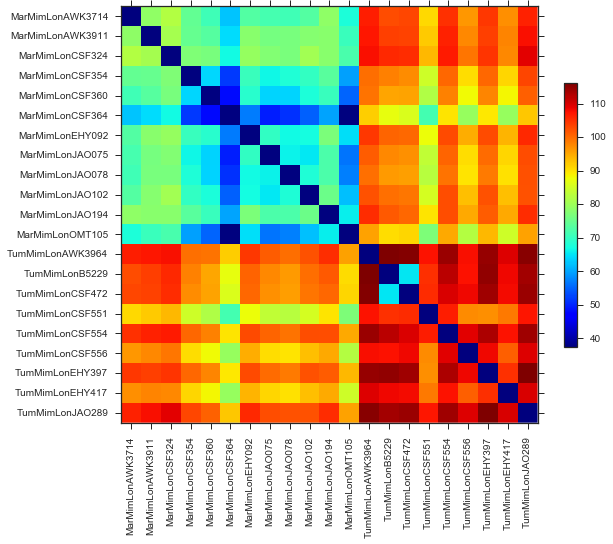

In [46]:
for species in ["Mimus"]:
#for species in species_list:
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=df_samples[0].values.tolist())

## Stats based on biallelic markers only

In [10]:
# Get Watterson's Theta per population
ThetaHat_mar = allel.stats.diversity.watterson_theta( range(1, len(g)), biallelic_mar)
ThetaHat_tum = allel.stats.diversity.watterson_theta( range(1, len(g)), biallelic_tum)
print(ThetaHat_mar, ThetaHat_tum)
TajD_mar = allel.stats.diversity.tajima_d( range(1, len(g)), biallelic_mar )
TajD_tum = allel.stats.diversity.tajima_d( range(1, len(g)), biallelic_tum )
print( "Tajima's D Mar = ", TajD_mar )
print( "Tajima's D Tum = ", TajD_tum )
# Print pairwise differences Dxy
Dxy = allel.stats.diversity.sequence_divergence( range(1, len(g)), biallelic_mar, biallelic_tum)
print( "Dxy = ",Dxy )
pf2 = allel.stats.admixture.patterson_f2(biallelic_mar, biallelic_tum)

0.0903663968874 0.162956864186
Tajima's D Mar =  2.43125199152
Tajima's D Tum =  1.50925107396
Dxy =  0.350069615494


In [439]:
## Site frequency spectrum early attempt.
## This is broken.
allel.stats.sf.joint_sfs_folded( biallelic_mar, biallelic_tum )


array([[1605, 4718, 4777,  763,  846,  181,  136,   47,    5,   13,    1,
           1],
       [1902,  466,  407,  164,  123,   44,   40,    4,    4,    3,    2,
           0],
       [3012,  523,  446,  106,   90,   18,    4,    3,    2,    1,    1,
           0],
       [ 163,   30,   35,    6,    9,    4,    5,    0,    0,    0,    1,
           0],
       [ 451,   26,  110,    4,   42,    2,    1,    2,    0,    0,    0,
           0],
       [  48,    4,    3,    0,    1,    0,   10,    0,    0,    0,    0,
           0],
       [  14,    1,    3,    1,    1,    0,    0,    0,    0,    0,    0,
           0],
       [   8,    0,    3,    0,    1,    0,    0,    0,    0,    0,    0,
           0],
       [   2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [441]:
pop1_idx = subpops[pop1]
pop2_idx = subpops[pop2]
a, b, c = allel.stats.weir_cockerham_fst(g, subpops=[pop1_idx, pop2_idx] , max_allele=1)
snp_fst_wc = (a / (a + b + c))[:, 0]
snp_fst_wc

array([-1.        , -1.        , -1.        , ..., -0.11846866,
        0.04289544, -0.0196135 ])

(array([  5.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   3.90000000e+01,
          0.00000000e+00,   0.00000000e+00,   8.17000000e+02,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.30000000e+01,   1.00000000e+00,
          7.00000000e+00,   6.60000000e+01,   1.00000000e+00,
          9.40000000e+01,   6.00000000e+00,   1.50000000e+01,
          1.19000000e+02,   6.00000000e+01,   2.33000000e+02,
        

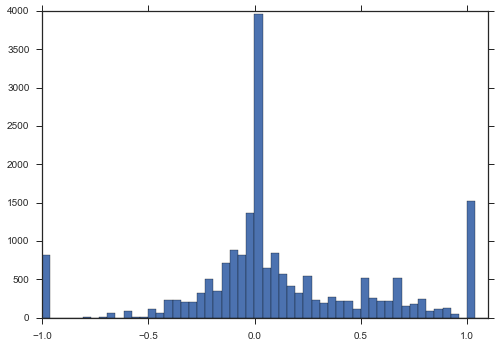

In [468]:
x = snp_fst_wc[~np.isnan(snp_fst_wc)]
plt.xlim(-1,1.1)
plt.hist(x, 100)

(array([  1.00000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.40000000e+01,
          0.00000000e+00,   1.30000000e+01,   0.00000000e+00,
          7.20000000e+01,   1.60000000e+01,   4.00000000e+00,
          0.00000000e+00,   7.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   1.20000000e+02,   0.00000000e+00,
          2.20000000e+01,   4.50000000e+01,   2.12000000e+02,
          2.82000000e+02,   3.40000000e+01,   9.70000000e+01,
          1.22000000e+02,   1.33000000e+02,   4.16000000e+02,
          6.11100000e+03,   1.41800000e+03,   1.30200000e+03,
          2.44000000e+02,   2.03400000e+03,   4.30000000e+01,
          1.47000000e+02,   2.00000000e+02,   3.40000000e+01,
          1.89000000e+02,   5.00000000e+01,   1.61700000e+03,
          5.20000000e+01,   1.77000000e+02,   3.66000000e+02,
        

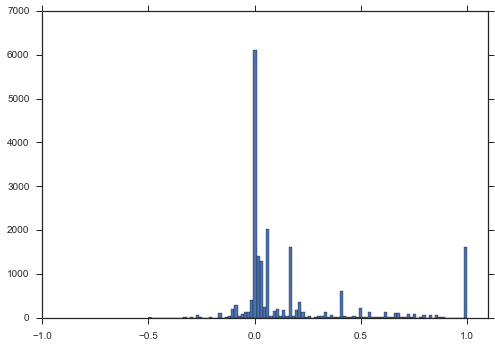

In [470]:
x = pf2[~np.isnan(pf2)]
plt.xlim(-1,1.1)
plt.hist(x, 100)

In [34]:
# Not stupid Pi
#ac_mar = g.count_alleles(subpop = np.where( df_samples[1] == pop1 )[0])
#print(ac_mar)
#np.where( df_samples[1] == pop1 )
#sum = 0
#for i in range(len(g)):
#    sum += allel.stats.sequence_diversity( i, ac_mar )/225
#print( "pi fix = ", sum/len(g))
print(allel.stats.sequence_diversity( range(1, len(g)), ac_mar ))
c

0.15058086094


rec.array([[(True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'), ...,
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0')],
 [(False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'), ...,
  (True, True, array([1, 0], dtype=int8), 0, 0, '1|0'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0')],
 [(False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'),
  (False, False, array([-1, -1], dtype=int8), 0, 0, './.'), ...,
  (True, True, array([0, 0], dtype=int8), 0, 0, '0|0'),
  (False, False, array([-1, -1], dtype=in

In [24]:
allel.SortedIndex(sorted(c['POS'][:]))

ValueError: no field of name POS

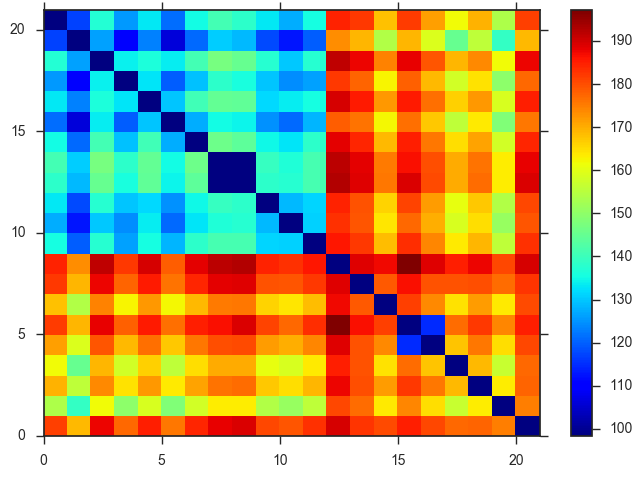

In [95]:
f = plt.figure()
wat = ensure_square(dist)
x = np.arange(0,22)
y = np.arange(0,22)
X, Y = np.meshgrid(x, y)
p = plt.pcolormesh(X, Y, np.flipud(wat), cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
#p = plt.pcolormesh(np.random.randn(10,10), cmap="jet")
p.axes.axis('tight')
cb = f.colorbar(p)
#cb.remove()
f.savefig("/Users/iovercast/Desktop/wat.svg", format="svg", dpi=1000)

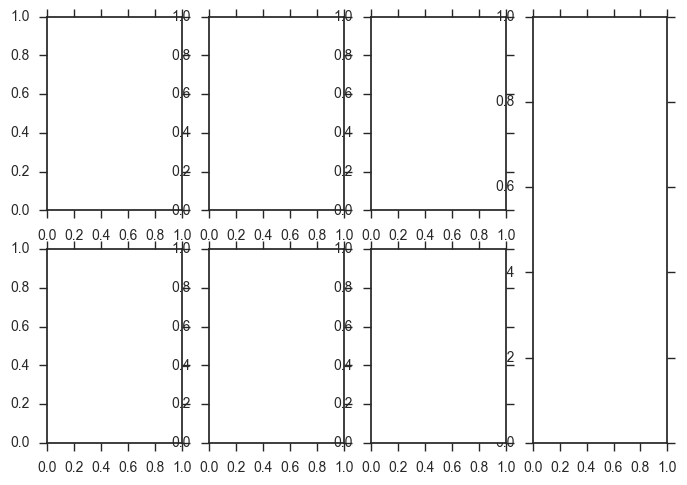

In [110]:
ax1 = plt.subplot2grid((2,4), (0, 0))
ax2 = plt.subplot2grid((2,4), (0, 1))
ax3 = plt.subplot2grid((2,4), (0, 2))
axbar = plt.subplot2grid((2,4), (0,3), rowspan=2)
ax4 = plt.subplot2grid((2,4), (1, 0))
ax5 = plt.subplot2grid((2,4), (1, 1))
ax5 = plt.subplot2grid((2,4), (1, 2))

In [143]:
tum_line[0]